
<a id='chap-tpreseauxneuronesmulticouches3'></a>

#  Reconnaissance de chiffres manuscrits par un réseau de neurones et un réseau de neurones convolutif


**L’objectif** de cette séance de TP est de comparer les performances d'un réseau dense avec celles d'un réseau convolutif. Comme Scikit-Learn ne permet pas la mise en oeuvre de CNN, ce sera également l'occasion pour nous de découvrir les bibliothèques Tensor Flow et en particulier Keras. 

### Données `digits`

Nous reprenons les [données digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html?highlight=digits#sklearn.datasets.load_digits), un ensemble d’images en faible résolution (8 x 8 pixels) de chiffres manuscrits, disponible dans Scikit-learn. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

(1797, 64)


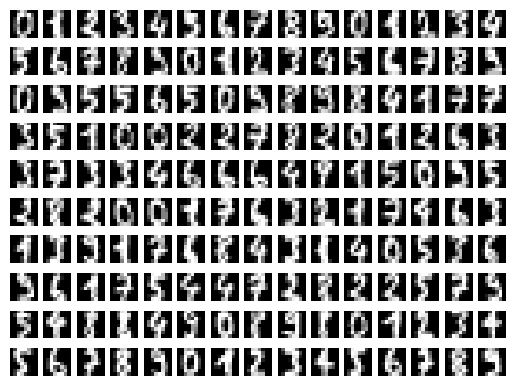

In [3]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
print(X.shape)
plt.figure(dpi=100)
for i in range(150):
    plt.subplot(10,15,i+1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')
    plt.axis('off')
plt.show()

On dispose donc de 1797 images de 8*8 (=64) pixels, représentant des chiffres manuscrits.
On commence comme d'habitude par séparer nos données d'apprentissage et de test :

In [4]:
np.random.seed(10)
from sklearn.model_selection import train_test_split
Xa, Xt, ya, yt = train_test_split(X, y, test_size=0.2)

## 1) Classification par un réseau de neurone linéaire à une couche cachée

Notre premier modèle est un perceptron multicouche linéaire à une couche cachée de 2 neurones :

In [5]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(2,), activation='identity', solver='adam', max_iter=5000, random_state=100)
clf.fit(Xa, ya)

MLPClassifier(activation='identity', hidden_layer_sizes=(2,), max_iter=5000,
              random_state=100)

Afficher les tailles des différentes couches du modèle

In [6]:
print("Matrice de poids entrées -> couche cachée : {}".format(clf.coefs_[0].shape))
print("Matrice de poids couche cachée -> sorties : {}".format(clf.coefs_[1].shape))

Matrice de poids entrées -> couche cachée : (64, 2)
Matrice de poids couche cachée -> sorties : (2, 10)


Effectuer l'apprentissage du modèle et calculer ses scores sur les données d'apprentissage et de test

In [7]:
def score(clf, X, y):
    return clf.score(X, y)

print("Score sur les données d'apprentissage : ", score(clf, Xa, ya))
print("Score sur les données de test : ", score(clf, Xt, yt))

Score sur les données d'apprentissage :  0.7988865692414753
Score sur les données de test :  0.7638888888888888


Ce n'est pas mal du tout pour un début!
Essayons de faire mieux :

A l'aide des paramètres appris du modèle (?coefs, ?intercept) recalculez (à la main car Scikit-learn ne conserve pas les résultats des couches cachées)  et affichez les valeurs des deux neurones de la couche cachée. Que constatez-vous?

In [8]:
hla = np.dot(Xa,clf.coefs_[0]) + clf.intercepts_[0]
hlt = np.dot(Xt,clf.coefs_[0]) + clf.intercepts_[0]

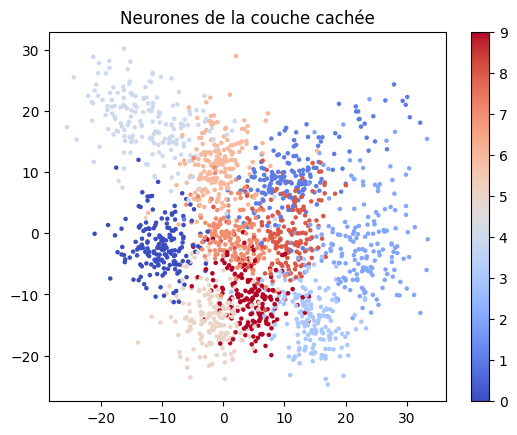

In [9]:
plt.figure()
plt.scatter(hla[:,0], hla[:,1], c=ya, cmap='coolwarm', s=5)
plt.scatter(hlt[:,0], hlt[:,1], c=yt, cmap='coolwarm', s=5)
plt.colorbar()
plt.title("Neurones de la couche cachée")
plt.show()

Quelle est votre analyse du résultat ?

Ici, on peut voir que les données sont visibles par des clusters, mais les clusters ne sont pas bien séparés. Pour autant, il y a autant de clusters que de chiffres à reconnaître. ce qui est plutôt bon signe.

## 2) Classification par un réseau non linéaire à plusieurs couches cachées

Notre deuxième modèle est un réseau de neurone à trois couches cachées de respectivement 40, 2 et  10 neurones et une fonction d’activation sigmoïde pour chaque couche. Examinez les valeurs obtenues dans la couche cachée de 2 neurones, a-t-on résolu le problème précédent?

In [12]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(40,2,10), activation='logistic', solver='adam', max_iter=5000, random_state=100)
clf.fit(Xa, ya)


MLPClassifier(activation='logistic', hidden_layer_sizes=(40, 2, 10),
              max_iter=5000, random_state=100)

On a bien progressé sur les données d'apprentissage, mais très peu sur les données de test.
Calculons les valeurs des couches cachées et affichons les résultats de la deuxième couche :

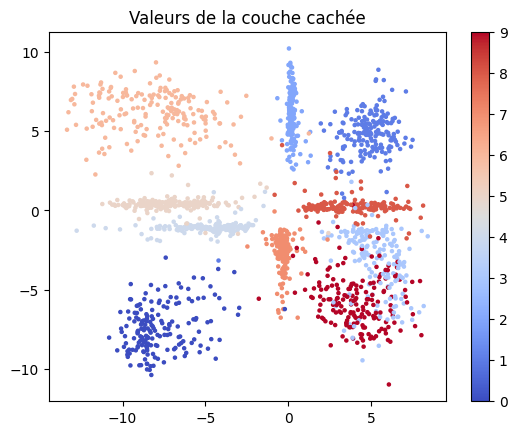

In [13]:
hl2a = np.dot(Xa,clf.coefs_[0]) + clf.intercepts_[0]
hl2a = 1/(1+np.exp(-hl2a))
hl2a = np.dot(hl2a,clf.coefs_[1]) + clf.intercepts_[1]

hl2t = np.dot(Xt,clf.coefs_[0]) + clf.intercepts_[0]
hl2t = 1/(1+np.exp(-hl2t))
hl2t = np.dot(hl2t,clf.coefs_[1]) + clf.intercepts_[1]

plt.figure()
plt.scatter(hl2a[:,0], hl2a[:,1], c=ya, cmap='coolwarm', s=5)
plt.scatter(hl2t[:,0], hl2t[:,1], c=yt, cmap='coolwarm', s=5)
plt.colorbar()
plt.title("Valeurs de la couche cachée")
plt.show()

Cette fois-ci les données ont bien été séparées par les premières couches 

## 3) Utilisation d'un réseau convolutif avec Keras

Scikit learn ne permet pas l'utilisation de réseaux convolutifs, c'est donc l'occasion de découvrir Tensor Flow, une nouvelle bibliothèque python que vous utiliserez largement en Master : 
https://www.tensorflow.org/?hl=fr 

In [14]:
# On commence par charger les bibliothèques nécessaires
import tensorflow as tf

2024-04-03 14:41:41.561400: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 14:41:41.561657: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 14:41:41.563776: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 14:41:41.591189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 14:41:42.190368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [15]:
from tensorflow import keras

In [16]:
# On charge Mnist depuis Keras
(xa, ya), (xt, yt) = keras.datasets.mnist.load_data()

xa = xa.reshape(-1,28,28,1)
xt  = xt.reshape(-1,28,28,1)

print("Données d'apprentissage : ",xa.shape)
print("Données de test : ",xt.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Données d'apprentissage :  (60000, 28, 28, 1)
Données de test :  (10000, 28, 28, 1)


On a maintenant 60000 données d'apprentissage de taille 28*28 et 10000 données de test
On a ajouté une dimension aux données pour avoir plusieurs couches de convolutions associées à la même image

In [17]:
# On normalise les données
xmax=xa.max()
xa = xa / xmax
xt  = xt  / xmax

## 1) Création de notre premier modèle Keras : Un réseau de neurones convolutif

In [18]:
# On met en place le réseau de neurones vu en cours
model = keras.models.Sequential()
model.add( keras.layers.Input((28,28,1)) )

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))# C'est nouveau ça?

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))# C'est nouveau ça?

model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(100, activation='relu'))
model.add( keras.layers.Dropout(0.5))# C'est nouveau ça?

model.add( keras.layers.Dense(10, activation='softmax'))

In [19]:
# On affiche les caractéristiques du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,358 (165.46 KB)

 Trainable params: 42,358 (165.46 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# On le crée
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# On paramètre et on lance l'apprentissage
batch_size  = 512
epochs      =  16
verb = 1 

history = model.fit(  xa, ya,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = verb,
                      validation_data = (xt, yt))

Epoch 1/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4499 - loss: 1.6142 - val_accuracy: 0.9291 - val_loss: 0.2754
Epoch 2/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8692 - loss: 0.4219 - val_accuracy: 0.9562 - val_loss: 0.1528
Epoch 3/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9142 - loss: 0.2798 - val_accuracy: 0.9677 - val_loss: 0.1097
Epoch 4/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9316 - loss: 0.2230 - val_accuracy: 0.9743 - val_loss: 0.0880
Epoch 5/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9446 - loss: 0.1835 - val_accuracy: 0.9777 - val_loss: 0.0759
Epoch 6/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9494 - loss: 0.1670 - val_accuracy: 0.9799 - val_loss: 0.0666
Epoch 7/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9524 - loss: 0.1547 - val_accuracy: 0.9810 - val_loss: 0.0613
Epoch 8/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9583 - loss: 0.1389 - val_accuracy: 

In [22]:
# Noter bien le contenu de l'historique
history.history

{'accuracy': [0.645883321762085,
  0.8838000297546387,
  0.9200166463851929,
  0.9345499873161316,
  0.9450666904449463,
  0.950083315372467,
  0.9530333280563354,
  0.9574666619300842,
  0.9605000019073486,
  0.9624000191688538,
  0.9645000100135803,
  0.965833306312561,
  0.9675833582878113,
  0.9678833484649658,
  0.9688500165939331,
  0.9697333574295044],
 'loss': [1.0777784585952759,
  0.3755281865596771,
  0.26386621594429016,
  0.21710170805454254,
  0.18163739144802094,
  0.16463971138000488,
  0.1524147391319275,
  0.14169572293758392,
  0.13158126175403595,
  0.12524941563606262,
  0.11808215081691742,
  0.1123373806476593,
  0.1075189858675003,
  0.10564421862363815,
  0.10335084050893784,
  0.09865917265415192],
 'val_accuracy': [0.929099977016449,
  0.9562000036239624,
  0.9677000045776367,
  0.9743000268936157,
  0.9776999950408936,
  0.9799000024795532,
  0.9810000061988831,
  0.9833999872207642,
  0.9843000173568726,
  0.9854999780654907,
  0.9861999750137329,
  0.98629

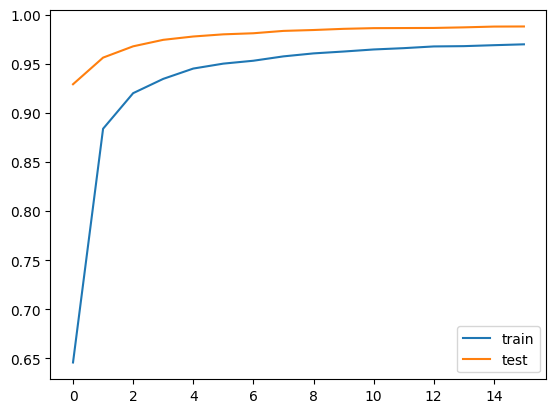

In [23]:
# Tracé des courbes d'apprentissages sur les données d'apprentissage et de test
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


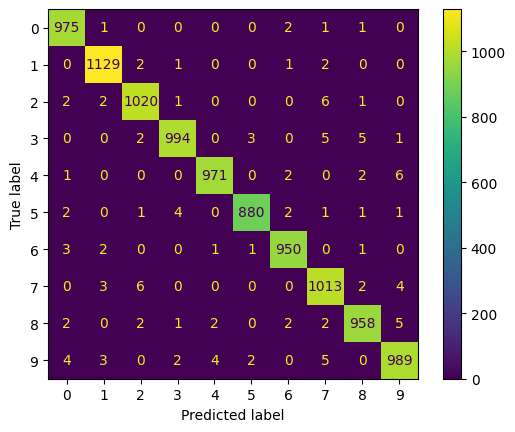

In [30]:
# Tracé de la matrice de confusion avec les valeurs prédites
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

yp = model.predict(xt)
yp = np.argmax(yp, axis=1)

cm = confusion_matrix(yt, yp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot()
plt.show()

